<div align = 'center'> Project 1 - Linear Regression and Model Comparison (LBA) 
    
<div align = 'center'> Macbeth K. Matibe
    
<div align = 'center'> Minerva University
    
<div align = 'center'> CS146: Computational Methods for Bayesian Statistics
    
<div align = 'center'> Prof. Volkan
    
<div align = 'center'> October 21, 2023

### Executive Summary: Housing Data Analysis

---


**Objective:**

The primary goal of this analysis was to understand the relationship between the distance to the nearest metro(MRT) station (`X3`) and the house price of unit area (`Y`), and to develop models that accurately predict house prices based on this distance.

**Key Findings:**

1. **Linear Relationship**: Initial exploration of the data showed a potential linear relationship between the distance to the nearest MRT station and house prices. A straightforward linear regression was fit to the data, providing a basic understanding of this trend. The data exhibited some anomalies which could potentially skew the results of a standard linear regression. To account for this a Student's T distribution was used for the likelihood which is more robust to outliers. 

3. **Complex Relationships**: A quadratic regression was explored to capture potential non-linear relationships in the data. This model assumes that the relationship between distance and house price is not just a straight line but may have some curvature. A Student's T distribution was also used for the quadratic model to combine the benefits of capturing non-linear relationships while also being resilient to outliers.

5. **Outlier Model**: A specialized outlier model was introduced, focusing explicitly on the potential outliers in the dataset. This model assigns a probability to each data point indicating its likelihood of being an outlier.

**Model Evaluation and Comparison:**

**PSIS-LOO**: PSIS leave-one-out cross-validation was employed for model comparison. A lower value indicates a preferable model. From the results the best model was the quadratic fit but the outlier detection model was a close contender with an overlapping credible interval to the quadratic model.

**Visual Analysis**: Various plots were generated to visually compare the fit of each model to the data. These visualizations reinforced the quantitative comparisons, providing a clear picture of which models fit the data best.

**Recommendations and Conclusions**:

1. Based on the PSIS-LOO metric, the quadratic model is recommended for predicting house prices based on distance to the nearest MRT station.
   
2. The presence of outliers suggests that while distance to MRT stations is a significant factor, other external factors might influence house prices. Further analysis may be needed to include the other predictor variables in the dataset and account for these factors in predicting the house price of unit area.
   
3. The quadratic model indicates that the relationship between distance and house price isn't strictly linear. As the distance increases, the rate at which the house price changes might also vary.

4. Stakeholders looking to set house prices or make property investments should consider both the distance to MRT stations and other potential factors not covered in this analysis but included in the dataset such as house age and number of convenience stores.

---

This analysis provides a comprehensive overview of the relationship between the distance to MRT stations and house prices. The models developed offer valuable insights and tools for stakeholders in the real estate industry. Future work should focus on including more variables to get a holistic view of the factors influencing house prices.

### Introduction

In the world of real estate, numerous factors play pivotal roles in determining property values. The dataset used in this analysis provides a comprehensive look into various determinants of real estate prices in Sindian Dist., New Taipei City, Taiwan, and was obtained from the UCI Machine Learning Repository. 

**Variables in the Dataset:**

The dataset comprises several input (independent) variables:

- **X1 (Transaction Date):** Represented in a unique manner, where, for instance, 2013.250 corresponds to March 2013, and 2013.500 translates to June 2013. This is the date when the house was purchased
- **X2 (House Age):** Age of the house in years.
- **X3 (Distance to Nearest MRT Station):** Proximity to the closest mass rapid transit station (metro), measured in meters.
- **X4 (Number of Convenience Stores):** An integer value that depicts the count of convenience stores accessible on foot.
- **X5 (Latitude) & X6 (Longitude):** Geographic coordinates of the property, measured in degrees.

The dataset's target (dependent) variable is:

- **Y (House Price of Unit Area):** Measured in 10,000 New Taiwan Dollar/Ping, where "Ping" is a local unit equivalent to 3.3 square meters.

#### Loading the Data and importing necessary Libraries

In [104]:
# Importing the necessary libraries
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sts
import pytensor.tensor as pt

# Loading the data from the CSV file
real_estate = pd.read_csv('Real estate.csv', encoding = 'utf-8')
print('This is the Real Estate data')
real_estate.head() 

This is the Real Estate data


,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


#### Data Visualization (Scatter Plots of House Price of Unit Area vs Each Independent Variable)

Next we visualize the scatter plot of the dependent variable, that is, the house price of a unit area against each independent variable to see what relationships exist between them and choose one independent variable to model. 

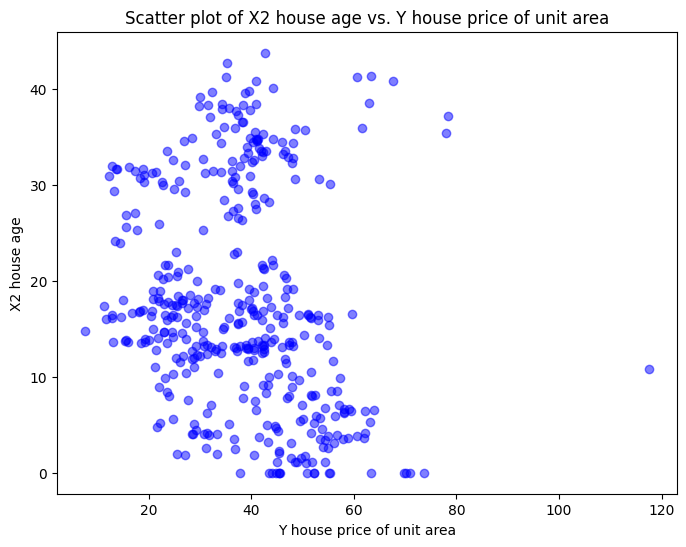

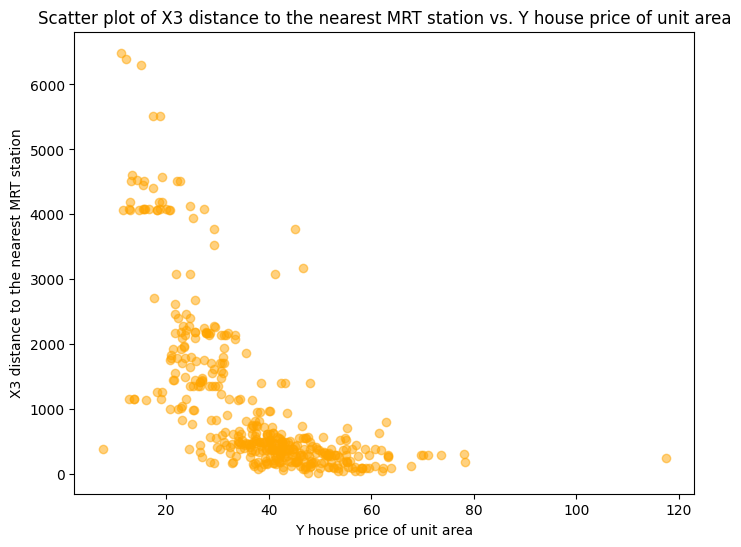

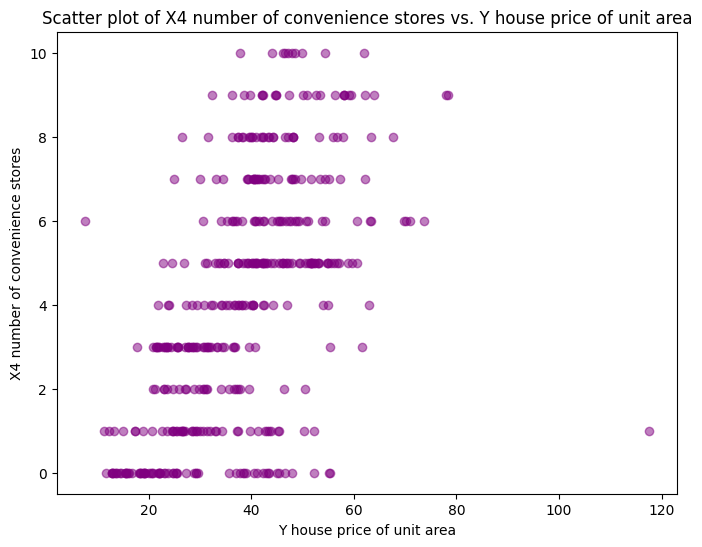

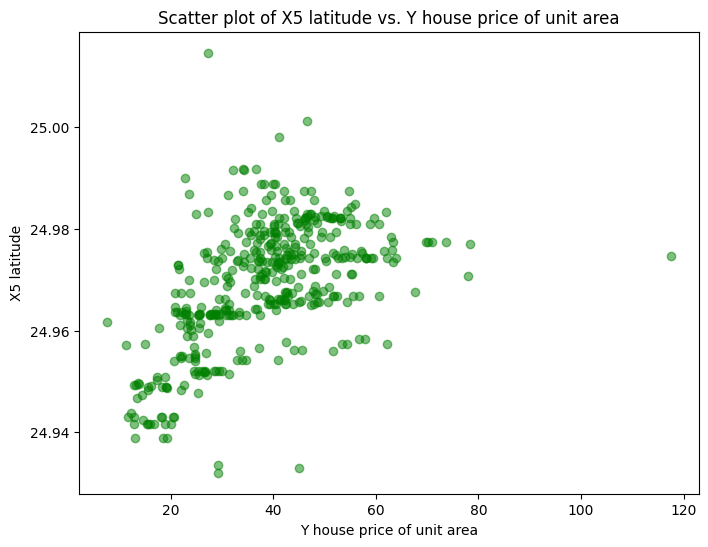

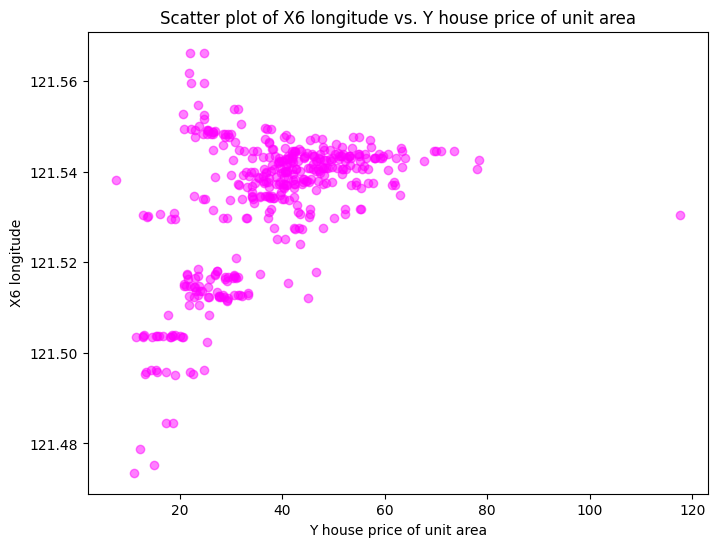

In [122]:
# List of columns to plot against 'house price'
except_col = {'Y house price of unit area', 'No', 'X1 transaction date'} # Don't make plots of these columns
columns_to_plot = [col for col in real_estate.columns if col not in except_col]

colour = ['blue', 'orange', 'purple', 'green', 'magenta']

for col, col_color in zip(columns_to_plot, colour):
    plt.figure(figsize = (8, 6))  
    plt.scatter(real_estate['Y house price of unit area'], 
                real_estate[col], color = col_color, alpha = 0.5)
    plt.title(f'Scatter plot of {col} vs. Y house price of unit area')
    plt.ylabel(col)
    plt.xlabel('Y house price of unit area')
    plt.show()

#### Choice of Independent Variable

From the scatter plots observed, several variables including X2 (house age), X3 (distance to the nearest MRT station), X4 (number of convenience stores), X5 (latitude), and X6 (longitude) demonstrate potential linear relationships with Y (house price of unit area). Among these variables, I have chosen to focus on X3 (distance to the nearest MRT station) for further analysis. My rationale for this selection is rooted in the belief that proximity to transportation amenities, particularly metro stations, is a crucial determinant for residential preferences. A residence situated near a metro station offers enhanced mobility and convenience, making it highly attractive to potential tenants. As evidenced by the scatter plot, there seems to be a discernible negative correlation: properties closer to metro stations typically command higher prices. For landlords, this proximity can be strategically leveraged as a unique selling point to prospective tenants.

### Model 1: Linear Model 


We aim to model the relationship between the house price of unit area (`Y`) and the distance to the nearest MRT station (`X3`). We can assume a linear relationship, described by the equation $$Y = a + bX3$$ a represents the intercept and b the slope of the line.

**Choosing Priors**:
1. **Intercept `a`**: We are adopting a uniform prior between 0 and 100, symbolized as $$a \sim \text{Uniform}(0, 100)$$ This means that, without seeing the data, we consider any value of `a` between 0 and 100 to be equally probable. This broad range ensures the model can adapt the intercept according to the observed data.

2. **Slope `b`**: Our initial assumption for the slope is a normal distribution centered at 0 with a standard deviation of 10, represented as $$b \sim \text{Normal}(0, 10)$$ This implies that we initially believe the relationship might be flat (slope around 0), but we allow for adjustments based on data insights. The standard deviation of 10 provides enough flexibility.

3. **Standard Deviation `sigma`**: Our belief for the variability in the observed data is captured by a uniform distribution for the standard deviation between 0 and 30, symbolized as $$\sigma \sim \text{Uniform}(0, 30)$$

**Likelihood**

We will be using the Student's T distribution, which offers robustness against potential outliers in the data. Compared to the more typical normal distribution, the Student's T distribution has thicker tails, accommodating extreme values more effectively.

**Degrees of Freedom `nu` for Student's T**: We'll employ a half-normal prior with a standard deviation of 30, denoted as $$\nu \sim \text{HalfNormal}(30)$$ The half-normal distribution is suitable for parameters that are strictly positive.


In [76]:
# Linear Model with Student T likelihood
with pm.Model() as linear_model:
    # Priors
    a = pm.Uniform('a', lower = 0, upper = 100)
    b = pm.Normal('b', mu = 0, sigma = 10)
    nu = pm.HalfNormal('nu', sigma = 30)  # degrees of freedom for Student's T
    sigma = pm.Uniform('sigma', 0, 30)
    
    # Data
    x = pm.MutableData('x', real_estate['X3 distance to the nearest MRT station'])
    y = pm.MutableData('y', real_estate['Y house price of unit area'])

    # Regression Mean (Linear Function)
    mu = pm.Deterministic('mu', a + b * x)
    
    # Likelihood using Student's T
    pm.StudentT('likelihood', nu = nu, mu = mu, sigma = sigma, observed = y)
    
    # Sampling
    linear_trace = pm.sample(tune = 1000, draws = 1000, chains = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, nu, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.


#### Checking the Sampler
We can check if the sampler works  by checking the trace plot, rank plot and the summary of the posterior.

**Trace Plot**

This displays the values of a given parameter across the  MCMC (Markov chain Monte Carlo) chains. Each chain is plotted as a separate line.

**Rank Plot**

This displays the rank of the sampled values across different chains. The values are ranked within each chain, and then the ranks are plotted against the cumulative distribution function (CDF) of a uniform distribution.

**ESS (Effective Sample Size)**

This measures the number of independent samples that our MCMC samples are equivalent to. It's a way to gauge the "efficiency" of our sampling process. Higher ESS values indicate that our chains have mixed well and that we have enough independent samples to make reliable inferences. A low ESS can suggest auto-correlation in the chain, which means consecutive samples might be too similar to each other and not exploring the parameter space efficiently. 
- ess_bulk: the effective sample size for the bulk of the distribution.
- ess_tail: effective sample size for the tail of the distribution.

**R_hat (Gelman-Rubin Diagnostic)**

This measures the convergence of the chains. It compares the variance between multiple chains to the variance within each chain.  If all chains have converged to the target distribution, the between-chain and within-chain variances should be roughly the same, giving an r-hat value close to 1. An r-hat significantly above 1 can indicate a lack of convergence.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,44.995,0.591,43.889,46.085,0.012,0.008,2465.0,2445.0,1.0
b,-0.007,0.000,-0.008,-0.006,0.000,0.000,2632.0,2550.0,1.0
nu,5.099,1.412,2.936,7.574,0.030,0.023,2580.0,2067.0,1.0
sigma,7.581,0.466,6.719,8.453,0.009,0.007,2481.0,2422.0,1.0


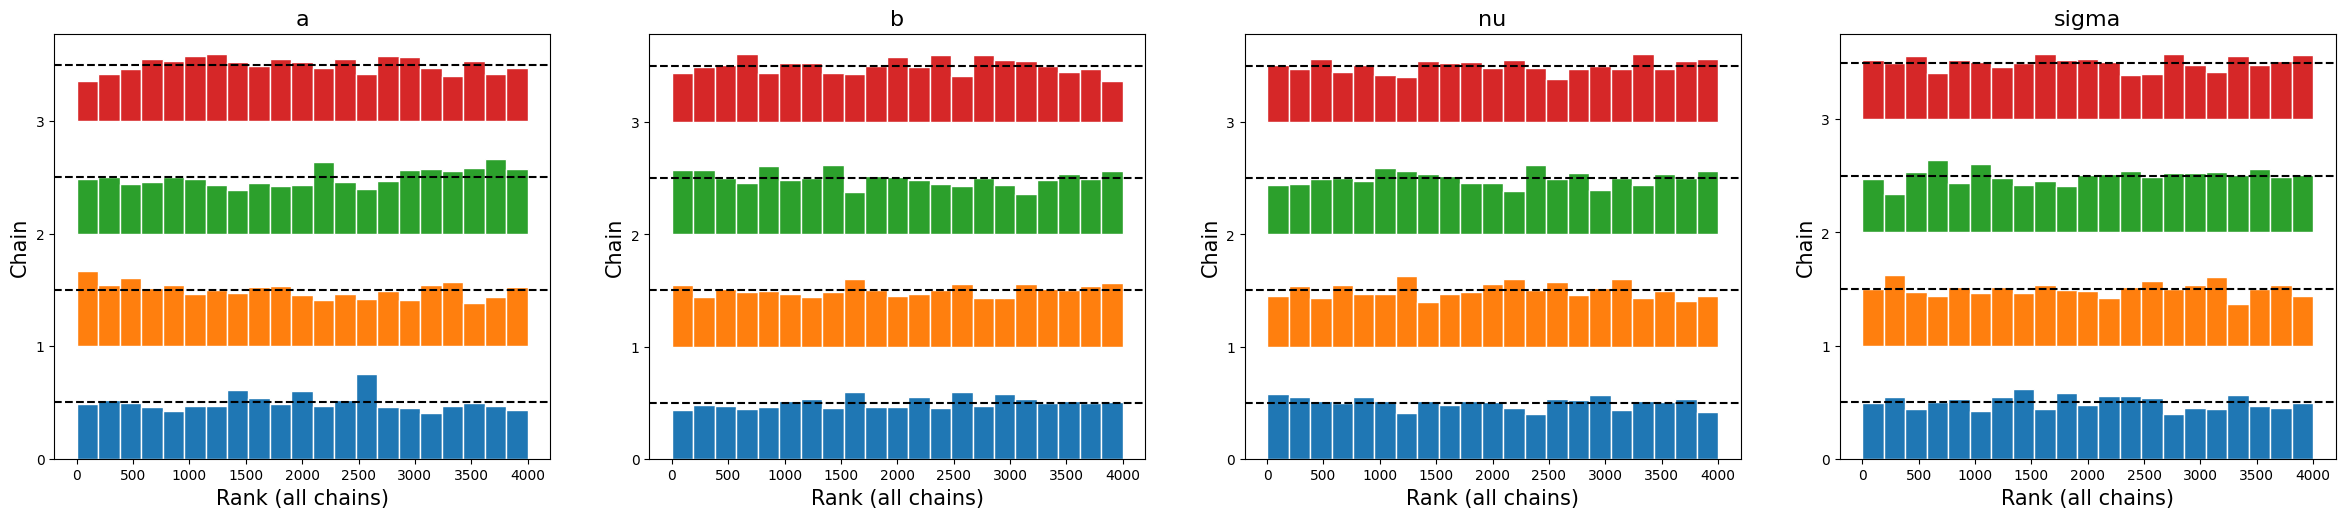

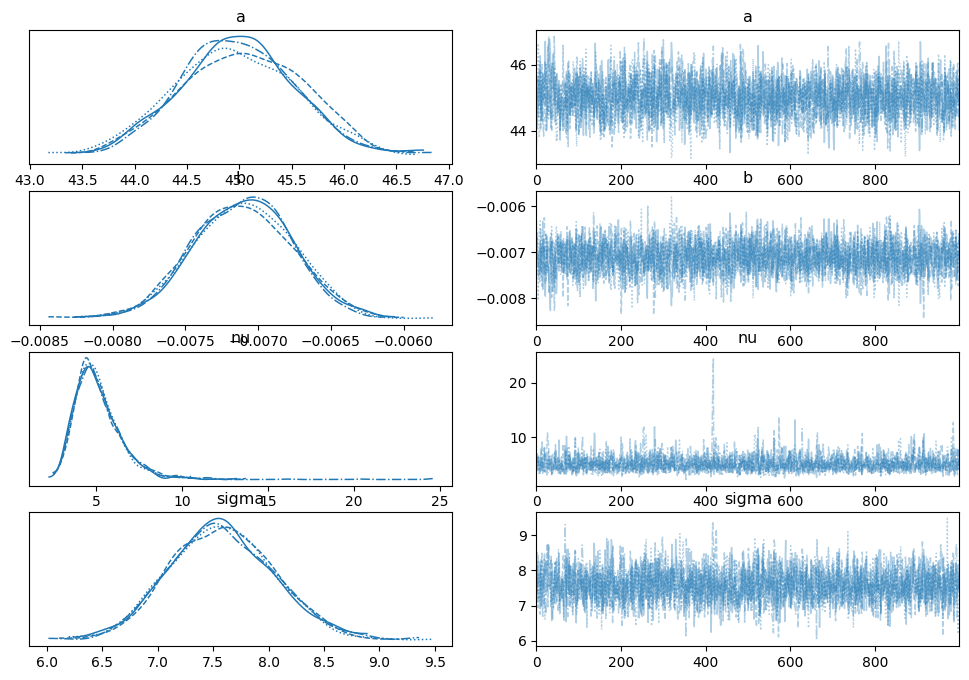

In [77]:
az.plot_rank(linear_trace, var_names=['a', 'b', 'nu', 'sigma'])
az.plot_trace(linear_trace, var_names=['a', 'b', 'nu', 'sigma'])
az.summary(linear_trace, var_names=['a', 'b', 'nu', 'sigma'])

**Trace and Rank Plots**

From the plots above, the sampler is working correctly. The rank plots all appear fairly uniform which indicates that the trace wasn't stuck in any particular place. In addition, from the trace plots, the distributions of the chains overlap nicely with each other which is an indication of convergence.

**Ess Values**

Both the ess_bulk and ess_tail are relatively high, indicating good sampling efficiency for both the main body and the tails of the distribution.

**r_hat values** 

The r_hat values are all 1 suggesting that the chains have converged well to the target posterior distribution, and our results are reliable.

#### Visualizing the Model fit
We can then visualize the line of best fit on the data and its credible interval.

/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


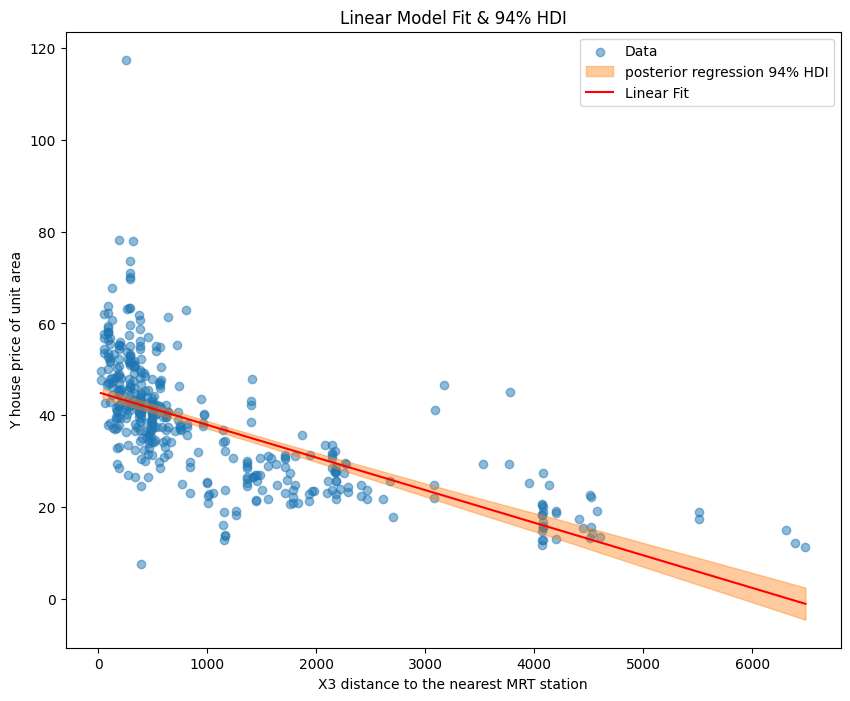

In [103]:
# Compute mean values for a and b
a_samples = linear_trace.posterior['a'].values.flatten()
b_samples = linear_trace.posterior['b'].values.flatten()

a_mean = a_samples.mean()
b_mean = b_samples.mean()

# Predicted values using the mean parameter estimates
x_vals = np.linspace(min(real_estate['X3 distance to the nearest MRT station']), 
                     max(real_estate['X3 distance to the nearest MRT station']), 1000)
y_vals = a_mean + b_mean * x_vals

# Compute posterior distributions of the predictions
posterior_mu = (a_samples[:, None] + b_samples[:, None] * x_vals)

# Plot the data with the line of best fit & HDI
plt.figure(figsize = (10, 8))
plt.scatter(real_estate['X3 distance to the nearest MRT station'], 
            real_estate['Y house price of unit area'], label = 'Data', alpha = 0.5)
az.plot_hdi(x_vals, posterior_mu, hdi_prob = 0.94, color = 'C1', 
            fill_kwargs = {'alpha': 0.4, 'label': 'posterior regression 94% HDI'})
plt.plot(x_vals, y_vals, c = 'red', label = 'Linear Fit') # the line
plt.title('Linear Model Fit & 94% HDI')
plt.xlabel('X3 distance to the nearest MRT station')
plt.ylabel('Y house price of unit area')
plt.legend()
plt.show()

From the plot we can see as initially suspected that there is an inverse relationship between the distance to the nearest metro station and the house price of a unit area. However, a linear fit doesn't fit the data that well and next we can do a quadratic fit to compare. 

### Model 2: Quadratic Model

The quadratic equation will allow us to model any inherent curvature we might observe between the proximity to the nearest metro station and the house price per unit area. For this model, we've introduced an additional parameter, c, which will account for the quadratic term of the distance variable, thereby adding a parabolic component to our regression function: 
$$μ = a + b × x + c × x^2$$
 Similar to the linear model, we'll employ the Student's T distribution for our likelihood to provide robustness against potential outliers. Our priors remain consistent with the linear model: a uniform distribution for the intercept, normal distributions for the linear and quadratic coefficients, a half-normal for the degrees of freedom of the Student's T, and another uniform for the error term. After setting up this structure, we'll proceed to sample from the posterior distribution, using four chains and 1000 samples each for both tuning and drawing.

In [99]:
# Quadratic Model using Student's T distribution
with pm.Model() as quadratic_model:
    # Priors
    a = pm.Uniform('a', lower = 0, upper = 100)
    b = pm.Normal('b', mu = 0, sigma = 10)
    c = pm.Normal('c', mu = 0, sigma = 10)  # quadratic term coefficient
    nu = pm.HalfNormal('nu', sigma = 30)  # degrees of freedom for Student's T
    sigma = pm.Uniform('sigma', 0, 30)

    # Data
    x = pm.MutableData('x', real_estate['X3 distance to the nearest MRT station'])
    y = pm.MutableData('y', real_estate['Y house price of unit area'])
    
    # Regression Mean (Quadratic function)
    mu = a + b * x + c * x**2
    
    # Likelihood using Student's T distribution
    pm.StudentT('likelihood', nu = nu, mu = mu, sigma = sigma, observed = y)
    
    # Sampling
    quadratic_trace = pm.sample(tune = 1000, draws = 1000, chains = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, nu, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 170 seconds.


#### Checking the Sampler

As done above, we use the trace plot, rank plot and summary of the posterior to check if the sampler is working correctly. 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,48.660,0.661,47.371,49.880,0.017,0.012,1580.0,1995.0,1.0
b,-0.015,0.001,-0.017,-0.013,0.000,0.000,1557.0,1709.0,1.0
c,0.000,0.000,0.000,0.000,0.000,0.000,1732.0,2195.0,1.0
nu,3.726,0.766,2.439,5.187,0.020,0.014,1491.0,1920.0,1.0
sigma,6.349,0.418,5.555,7.132,0.012,0.008,1289.0,1619.0,1.0


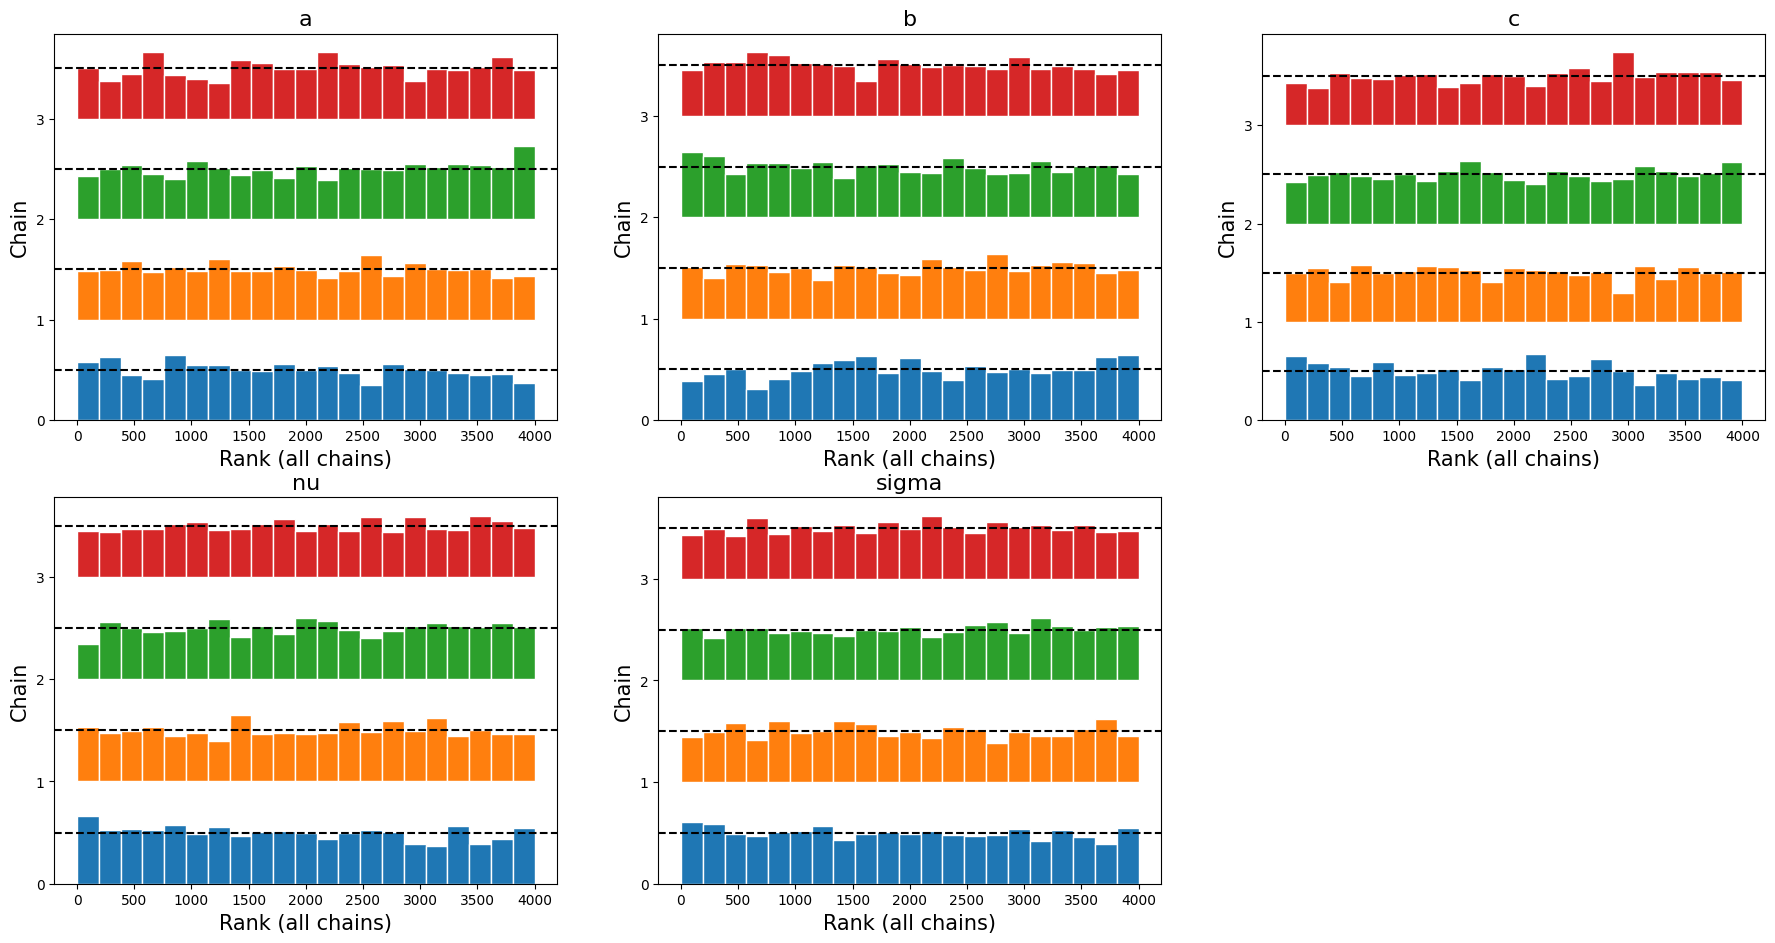

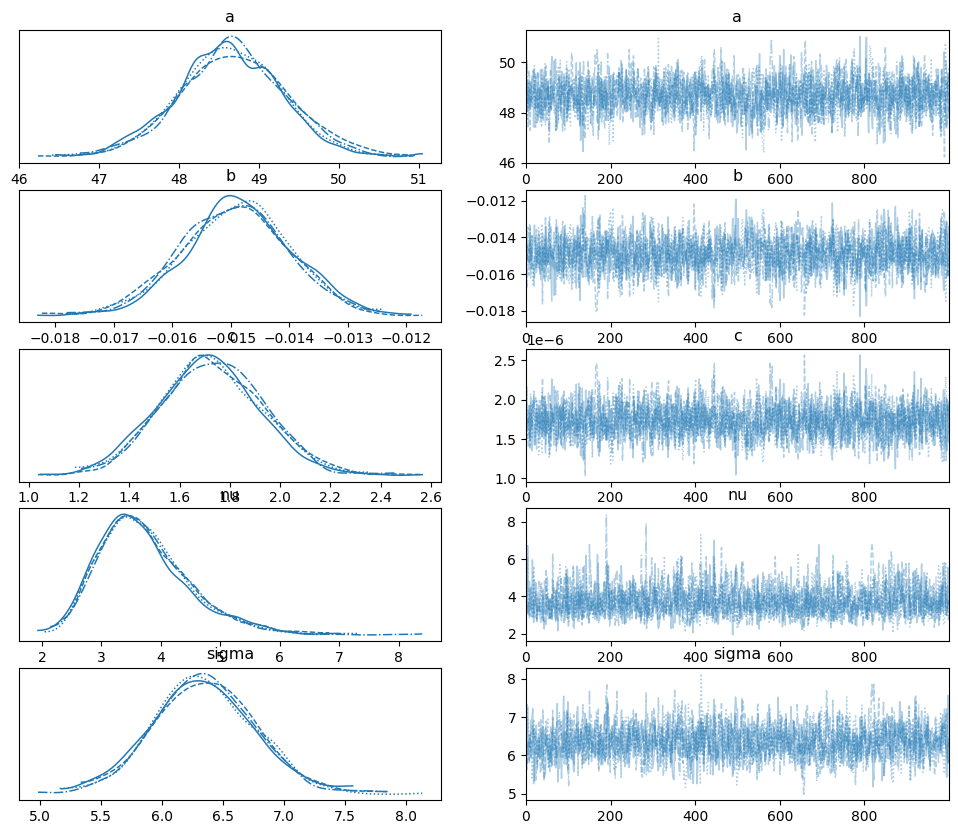

In [100]:
az.plot_rank(quadratic_trace, var_names=['a', 'b', 'c', 'nu', 'sigma'])
az.plot_trace(quadratic_trace, var_names=['a', 'b', 'c', 'nu', 'sigma'])
az.summary(quadratic_trace, var_names=['a', 'b', 'c', 'nu', 'sigma'])

**Trace and Rank Plots**

From the plots above, the sampler is working correctly. The rank plots all appear fairly uniform which indicates that the trace wasn't stuck in any particular place. In addition, from the trace plots, the distributions of the chains overlap nicely with each other which is an indication of convergence.

**Ess Values**

Both the ess_bulk and ess_tail are relatively high, indicating good sampling efficiency for both the main body and the tails of the distribution.

**r_hat values** 

The r_hat values are all 1 indicating that the chains have converged well to the target posterior distribution, and our results are reliable.

#### Visualizing the Model fit
As above, we then visualize the line of best fit on the data and its credible interval.

/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


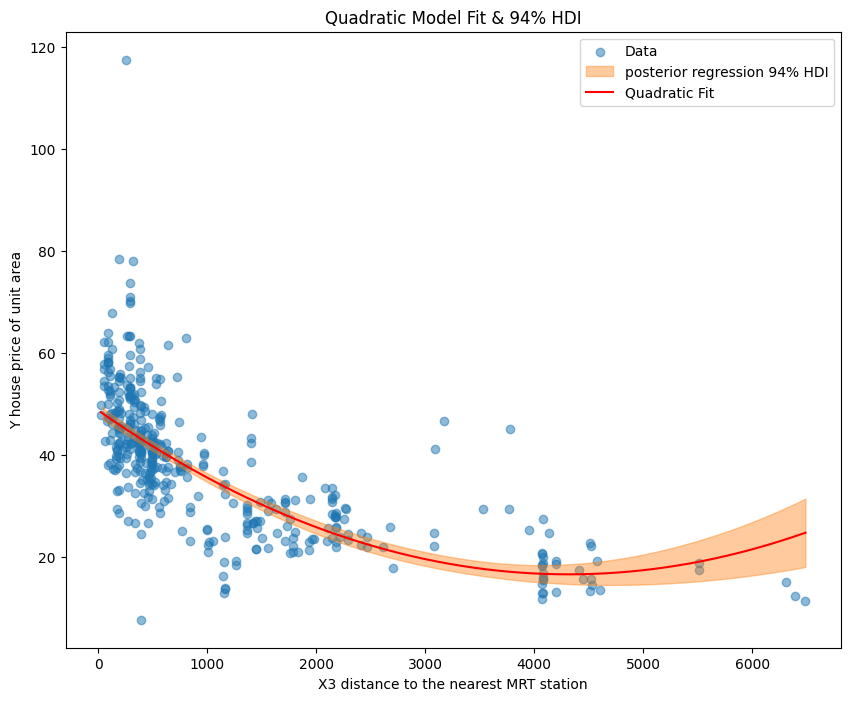

In [102]:
# Computing mean values for the coefficients from the trace
a2_samples = quadratic_trace.posterior['a'].values.flatten()
b2_samples = quadratic_trace.posterior['b'].values.flatten()
c_samples = quadratic_trace.posterior['c'].values.flatten()

a2_mean = a2_samples.mean()
b2_mean = b2_samples.mean()
c_mean = c_samples.mean()

# Generate predicted values using the mean parameter estimates
x_vals2 = np.linspace(min(real_estate['X3 distance to the nearest MRT station']), 
                     max(real_estate['X3 distance to the nearest MRT station']), 1000)
y_vals_q = a2_mean + b2_mean * x_vals2 + c_mean * x_vals2**2

# Compute posterior distributions of the predictions
posterior_mu_q = (a2_samples[:, None] + b2_samples[:, None] * x_vals2 +
                       c_samples[:, None] * x_vals2**2)

# Plot the data with the line of best fit & HDI
plt.figure(figsize = (10, 8))
plt.scatter(real_estate['X3 distance to the nearest MRT station'], 
            real_estate['Y house price of unit area'], label = 'Data', alpha = 0.5)
ax = az.plot_hdi(x_vals2, posterior_mu_q, hdi_prob = 0.94, color = 'C1', 
                 fill_kwargs={'alpha': 0.4, 'label': 'posterior regression 94% HDI'})
plt.plot(x_vals2, y_vals_q, c = 'red', label = 'Quadratic Fit')
plt.title('Quadratic Model Fit & 94% HDI')
plt.xlabel('X3 distance to the nearest MRT station')
plt.ylabel('Y house price of unit area')
plt.legend()
plt.show()

This seems to be a better fit than the linear one but we can only know for sure after checking certain metrics such as the WAIC. There is more uncertainty shown by the wider credible interval towards the end. This can be attributed to less data compared to the first part with a lot of data points. The data also has outliers and is a good candidate for the outlier detection model which is done below. 

### Model 3: Outlier Detection Model

This model is tailored not just to capture the primary trend in the data but also to specifically account for outliers.

**Priors:**

The intercept, a, will be assumed to lie uniformly between 0 and 100, reflecting our open-mindedness about its exact value. For the slope coefficients of the linear and quadratic terms, b and c respectively, we'll assume normal distributions, hinting at our initial neutral expectation about their values just as done in the quadratic model.

**Model Framework:**

The underlying relationship will be represented as a quadratic function, offering a flexible fit to potentially curved trends in the data.

**Likelihood**

The Bernoulli distribution is a discrete probability distribution for a random variable which can take on one of two possible outcomes. Mathematically, a Bernoulli random variable Y is given by: $$P(Y = 1) = p$$ $$P(Y = 0) = 1 − p$$

Where:
- Y = 1 represents one outcome (in our case, a data point being an outlier).
- Y = 0 represents the other outcome (a data point being an inlier).
- p is the probability of the first outcome (i.e., the probability that a data point is an outlier).

In the model: $$is outlier ∼ Bernoulli$$

Here:
- is_outlier is a binary indicator for each data point, where 1 indicates it's an outlier and 0 indicates it's an inlier.
- p is the prior probability that a given data point is an outlier. This is modeled as a uniform distribution between 0 and 0.5, indicating our prior belief that not more than half of the data points can be outliers.

During the sampling process:
- For each data point, the model assesses the likelihood of it being an outlier versus an inlier based on the current parameter estimates.
- Based on these likelihoods and the prior distribution of p, the Bernoulli process decides whether the data point is more likely to be an outlier or an inlier.

**Inliers:**

For the data points that are considered 'inliers' or regular data points, the likelihood is given by: $$y ∼ N(μ,σ^2)$$ 
Where:
- y is the house price of unit area.
- N denotes the normal distribution.
- μ is the expected value of y given by our quadratic function: 
$$μ = a + b × x + c × x^2$$ 
- σ^2 is the variance of the inliers, which quantifies the extent to which individual data points can deviate from the mean.
  
**Outliers:**

For the data points that are tagged as 'outliers', the likelihood changes slightly: $$y ∼ N(μ,(σ + σ out)^2)$$
​
Here:
- σout represents the additional variance associated with the outliers. This ensures that our model is more lenient or forgiving to the deviations of these data points from the mean.

This flexible likelihood construction allows our model to cater to both the main trend in the data and the potential outliers. The dual variance structure ensures that outliers are given the room to deviate from the mean without overly influencing the model's overall fit.



In [105]:
with pm.Model() as outlier_model:
    # Priors
    a = pm.Uniform('a', lower = 0, upper = 100)
    b = pm.Normal('b', mu = 0, sigma = 10)
    c = pm.Normal('c', mu = 0, sigma = 5)

    # Data
    x = pm.MutableData('x', real_estate['X3 distance to the nearest MRT station'])
    y = pm.MutableData('y', real_estate['Y house price of unit area'])

    # Regression Mean (Quadratic function)
    mu = pm.Deterministic('mu', a + b * x + c * x**2)
    
    # Noise parameters for inliers and outliers
    sigma = pm.Uniform('sigma', lower = 0, upper = 100)
    sigma_out = pm.HalfNormal('sigma_out', sigma = 30)
    sigmas = pm.math.stack([sigma, sigma + sigma_out])

    # In/out class assignment probability and indicators
    p = pm.Uniform('p', lower = 0, upper = 0.5)
    is_outlier = pm.Bernoulli('is_outlier', p = p, size = x.shape[0])
    
    pm.Normal('likelihood', mu = mu, sigma = sigmas[is_outlier], observed = y)

    # Sampling
    outlier_trace = pm.sample(2000, tune = 1000, chains = 4)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, b, c, sigma, sigma_out, p]
>BinaryGibbsMetropolis: [is_outlier]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 320 seconds.
/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


#### Checking the Sampler

As done for the linear and quadratic model, we use the trace plot, rank plot and summary of the posterior to check if the sampler is working correctly. 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,48.846,0.682,47.545,50.116,0.019,0.013,1357.0,2148.0,1.00
b,-0.015,0.001,-0.017,-0.013,0.000,0.000,1381.0,2114.0,1.00
sigma,6.566,0.535,5.513,7.510,0.028,0.020,384.0,516.0,1.01
sigma_out,12.923,3.270,7.722,18.685,0.169,0.120,380.0,931.0,1.01
p,0.156,0.063,0.050,0.276,0.004,0.003,286.0,407.0,1.02


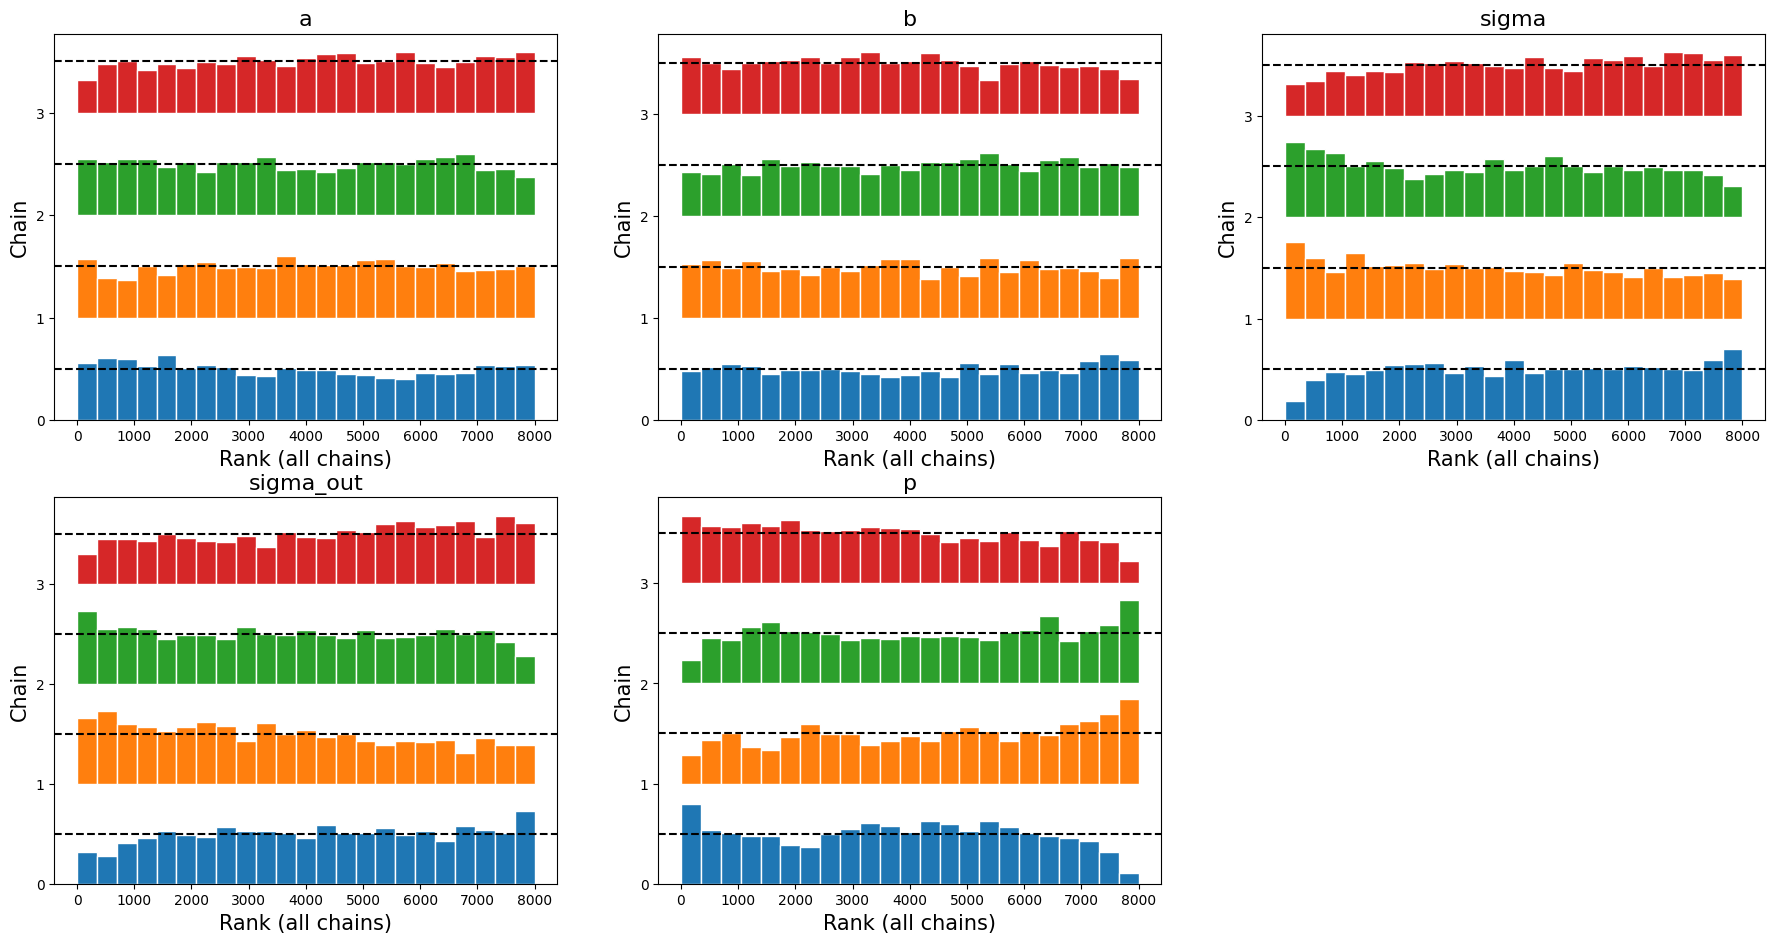

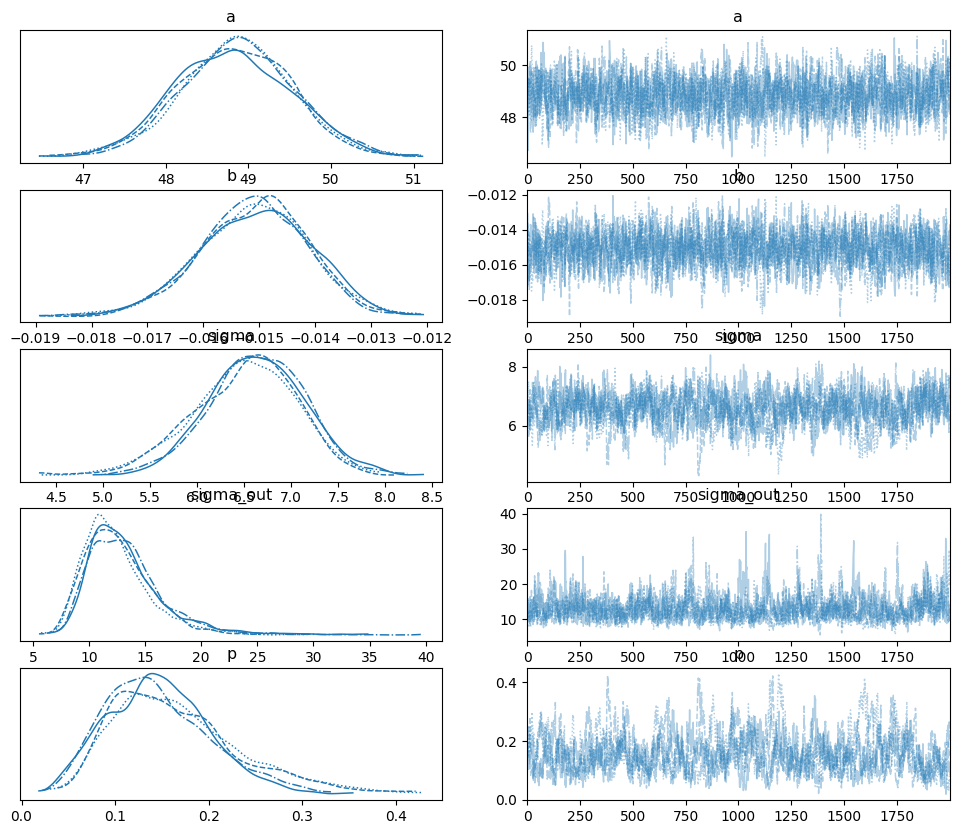

In [106]:
az.plot_rank(outlier_trace, var_names=['a', 'b', 'sigma', 'sigma_out', 'p'])
az.plot_trace(outlier_trace, var_names=['a', 'b', 'sigma', 'sigma_out', 'p'])
az.summary(outlier_trace, var_names=['a', 'b', 'sigma', 'sigma_out', 'p'])


**Trace and Rank Plots**

From the plots above, the sampler is working correctly. The rank plots all appear fairly uniform which indicates that the trace wasn't stuck in any particular place. In addition, from the trace plots, the distributions of the chains overlap nicely with each other which is an indication of convergence.

**Ess Values**

Both the ess_bulk and ess_tail are relatively high, indicating good sampling efficiency for both the main body and the tails of the distribution.

**r_hat values** 

The r_hat values are all 1 indicating that the chains have converged well to the target posterior distribution, and our results are reliable.


#### Visualizing the Model fit

/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


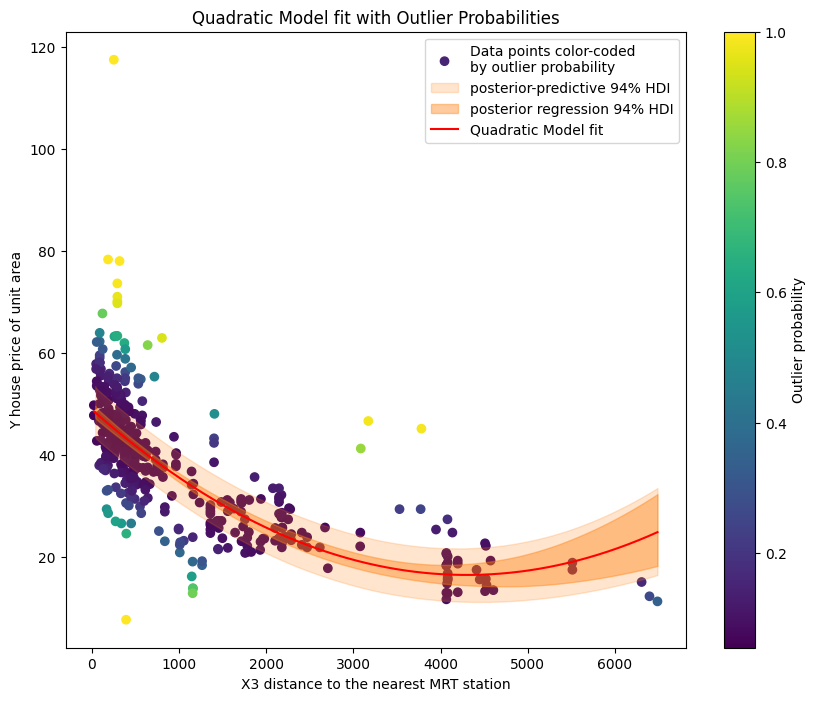

In [113]:
# Extracting mean values for the coefficients from the trace
a3_samples = outlier_trace.posterior['a'].values.flatten()
b3_samples = outlier_trace.posterior['b'].values.flatten()
c2_samples = outlier_trace.posterior['c'].values.flatten()

a3_mean = a3_samples.mean()
b3_mean = b3_samples.mean()
c2_mean = c2_samples.mean()

# Predicted values using the mean parameter estimates
x_vals3 = np.linspace(min(real_estate['X3 distance to the nearest MRT station']), 
                     max(real_estate['X3 distance to the nearest MRT station']), 1000)
y_vals3 = a3_mean + b3_mean * x_vals3 + c2_mean * x_vals3**2


# Compute posterior distributions of the predictions
posterior_mu_out = (a3_samples[:, None] + b3_samples[:, None] * x_vals3 +
                c2_samples[:, None] * x_vals3**2)
posterior_y = np.random.normal(posterior_mu_out, np.sqrt(outlier_trace.posterior['sigma'].values.flatten())[:, None])


# Probability of each data point being an outlier
outlier_prob = outlier_trace.posterior['is_outlier'].values.mean(axis = (0, 1))

# Plotting quadratic fit and HDI for regression and posterior predictions
plt.figure(figsize = (10, 8))
plt.scatter(real_estate['X3 distance to the nearest MRT station'], 
            real_estate['Y house price of unit area'], c = outlier_prob, cmap = 'viridis', 
            label='Data points color-coded\nby outlier probability')
ax = az.plot_hdi(x_vals3, posterior_y, hdi_prob = 0.94, color = 'C1', 
                 fill_kwargs = {'alpha': 0.2, 'label': 'posterior-predictive 94% HDI'})
az.plot_hdi(x_vals3, posterior_mu_out, ax = ax, hdi_prob = 0.94, color = 'C1', 
            fill_kwargs = {'alpha': 0.4, 'label': 'posterior regression 94% HDI'})
plt.plot(x_vals3, y_vals3, 'r-', label = 'Quadratic Model fit')
plt.colorbar(label = 'Outlier probability')
plt.xlabel('X3 distance to the nearest MRT station')
plt.ylabel('Y house price of unit area')
plt.title('Quadratic Model fit with Outlier Probabilities')
plt.legend()
plt.show()


From the plot, using a Bernoulli-based mechanism to probabilistically tag each data point as an outlier or inlier is effective. The model captures the main trend of the data, but it also identifies the outliers without being overly influenced by them. This balanced approach ensures that the model isn't skewed by extreme values but is still sensitive enough to recognize and account for them. 

### Comparison of the 3 Models: PSIS leave-one-out cross-validation

We use PSIS leave-one-out cross-validation (LOO CV) to compare the performance of our three models. PSIS stands for Pareto Smoothed Importance Sampling, a technique employed to stabilize and improve the accuracy of importance sampling, which is a foundational component of LOO CV. 

Leave-one-out cross-validation, is a process where one observation is left out of the dataset at a time, and the model is trained on the remaining data and validated on the left-out data point. This is repeated for every observation in the dataset, resulting in a comprehensive evaluation metric. LOO CV estimates the out-of-sample predictive performance of a model using the posterior samples without the need for traditional cross-validation. Essentially, by comparing the LOO CV scores of our models, we can determine which model is likely to make better predictions on new, unseen data. Higher LOO CV scores indicate better model fit and predictive accuracy.

In [115]:
# For Linear Model
with linear_model:
    pm.compute_log_likelihood(linear_trace)
loo_linear = az.loo(linear_trace, pointwise=True, scale='deviance')

# For Quadratic Model
with quadratic_model:
    pm.compute_log_likelihood(quadratic_trace)
loo_quadratic = az.loo(quadratic_trace, pointwise=True, scale='deviance')

# For Outlier Model
with outlier_model:
    pm.compute_log_likelihood(outlier_trace)
loo_outlier = az.loo(outlier_trace, pointwise=True, scale='deviance')


/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the margin

           rank     elpd_loo      p_loo  elpd_diff        weight         se  \
Quadratic     0 -1476.544040   5.486751   0.000000  6.705827e-01  20.879266   
Outlier       1 -1478.934296  68.997218   2.390256  3.294173e-01  21.529037   
Linear        2 -1518.527683   4.845089  41.983643  1.641354e-12  19.987291   

                dse  warning scale  
Quadratic  0.000000    False   log  
Outlier    5.509130     True   log  
Linear     6.286504     True   log  


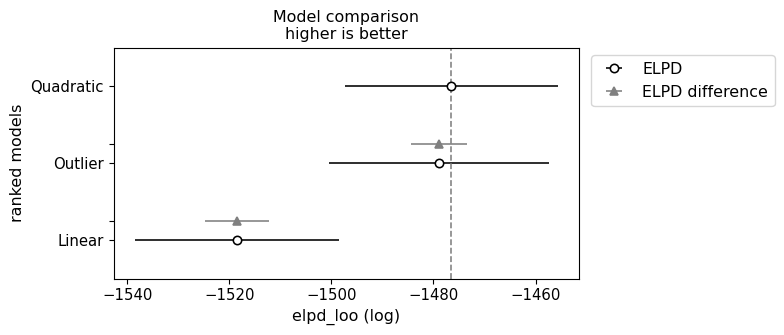

In [117]:
# Compare the models using arviz.compare
comparison_loo = az.compare({
    'Linear': linear_trace,
    'Quadratic': quadratic_trace,
    'Outlier': outlier_trace
}, ic='loo')

print(comparison_loo)

# Visualizing the comparison
az.plot_compare(comparison_loo)
plt.show()


From the plot above, the quadratic model is the best but the outlier model is also a very close contender. The linear model is very far off from the other two and doesn't seem to fit the data very well. 

## References

UCI Machine Learning Repository. (2018). Real estate valuation data set. Retrieved from https://doi.org/10.24432/C5J30W. Licensed under Creative Commons Attribution 4.0 International (CC BY 4.0).

Volkan, E. (2023). Computational Methods for Bayesian Statistics (Sessions 7 & 8). Minerva University.

#### AI Policy Statement

Grammarly to correct for errors and I also used ChatGPT to cut back on words for some parts and create an outline for the executive summary. 